In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
# Inline plotting
%matplotlib inline
import scanpy as sc
import scrublet as scr
from pathlib import Path
import palantir

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')  # low dpi (dots per inch) yields small inline figures

#Low salt
DATA_DIR_low_salt = Path("./output_data/low_salt/") 
DATA_DIR_low_salt.mkdir(parents=True, exist_ok=True)

FILE_NAME_low_salt = DATA_DIR_low_salt / "low_salt.h5ad"

#High salt
DATA_DIR_high_salt = Path("./output_data/high_salt/") 
DATA_DIR_high_salt.mkdir(parents=True, exist_ok=True)

FILE_NAME_high_salt = DATA_DIR_high_salt / "high_salt.h5ad"

-----
anndata     0.8.0
scanpy      1.9.1
-----
Cython              0.29.34
PIL                 9.3.0
annoy               NA
asttokens           NA
backcall            0.2.0
cairo               1.21.0
cffi                1.15.1
colorama            0.4.6
cycler              0.10.0
cython              0.29.34
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.3
decorator           5.1.1
defusedxml          0.7.1
entrypoints         0.4
executing           1.2.0
fcsparser           0.2.4
fontTools           4.38.0
h5py                3.7.0
igraph              0.10.2
ipykernel           6.17.1
ipython_genutils    0.2.0
ipywidgets          8.0.2
jedi                0.18.1
joblib              1.2.0
kiwisolver          1.4.4
lazy_loader         NA
leidenalg           0.9.0
llvmlite            0.36.0
louvain             0.8.0
matplotlib          3.6.2
matplotlib_inline   0.1.6
mpl_toolkits        NA
natsort             8.2.0
networkx            2.8.8
nt                  N

In [12]:
#Low salt
adata_low_salt = sc.read_10x_mtx(
    './raw_data/0170/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)  

adata_low_salt
adata_low_salt.obs['Condition'] = 'low salt'
adata_low_salt.obs

#doublet removal
scrub = scr.Scrublet(adata_low_salt.X)
adata_low_salt.obs['doublet_scores'], adata_low_salt.obs['predicted_doublets'] = scrub.scrub_doublets()

adata_low_salt.obs['doublet_info'] = adata_low_salt.obs['predicted_doublets']
adata_low_salt = adata_low_salt[adata_low_salt.obs['doublet_info'] == False, :]

... reading from cache file cache\raw_data-0170-matrix.h5ad
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 42.9%
Elapsed time: 13.9 seconds


In [13]:
adata_high_salt = sc.read_10x_mtx(
    './raw_data/0171/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)  

adata_high_salt

adata_high_salt.obs['Condition'] = 'high salt'
adata_high_salt.obs

#doublet removal
scrub = scr.Scrublet(adata_high_salt.X)
adata_high_salt.obs['doublet_scores'], adata_high_salt.obs['predicted_doublets'] = scrub.scrub_doublets()

adata_high_salt.obs['doublet_info'] = adata_high_salt.obs['predicted_doublets']
adata_high_salt = adata_high_salt[adata_high_salt.obs['doublet_info'] == False, :]

... reading from cache file cache\raw_data-0171-matrix.h5ad
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.55
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 0.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 13.1%
Elapsed time: 8.3 seconds


In [14]:
# Merge high and low salt data into one object

# Concatenate the two objects along the observation axis (i.e., rows)
adata = adata_high_salt.concatenate(adata_low_salt, index_unique="_", join = "outer")

# Update the observation (cell) annotation with the treatment information
treatment = ['high_salt'] * adata_high_salt.n_obs + ['low_salt'] * adata_low_salt.n_obs
adata.obs['treatment'] = treatment
adata.obs

c:\users\mahim\appdata\local\programs\python\python39\lib\site-packages\anndata\_core\anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


,Condition,doublet_scores,predicted_doublets,doublet_info,batch,treatment
AAACCTGAGATCCGAG-1_0,high salt,0.203931,False,False,0,high_salt
AAACCTGAGCAAATCA-1_0,high salt,0.106977,False,False,0,high_salt
AAACCTGAGGAGTTGC-1_0,high salt,0.227882,False,False,0,high_salt
AAACCTGCACGAGGTA-1_0,high salt,0.084337,False,False,0,high_salt
AAACCTGGTCGCGTGT-1_0,high salt,0.227882,False,False,0,high_salt
...,...,...,...,...,...,...
TTTGTCATCGCTTAGA-1_1,low salt,0.215686,False,False,1,low_salt
TTTGTCATCGGAAATA-1_1,low salt,0.188235,False,False,1,low_salt
TTTGTCATCTCCGGTT-1_1,low salt,0.113543,False,False,1,low_salt
TTTGTCATCTGAAAGA-1_1,low salt,0.352941,False,False,1,low_salt


In [15]:
# Data processing
sc.pp.normalize_per_cell(adata)
palantir.preprocess.log_transform(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=1500)
sc.pp.pca(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


In [16]:
# Diffusion map
pca_projections = pd.DataFrame(adata.obsm['X_pca'], index=adata.obs_names)
dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components=5)
ms_data = palantir.utils.determine_multiscale_space(dm_res)

Determing nearest neighbor graph...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


c:\users\mahim\appdata\local\programs\python\python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


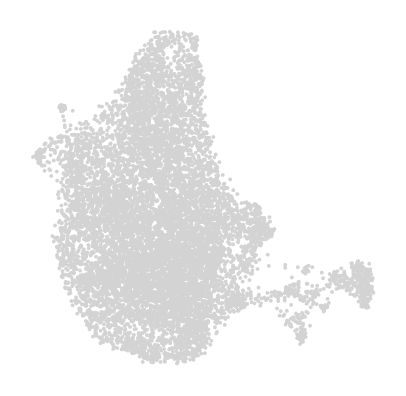

In [17]:
# Visualization
sc.pp.neighbors(adata)
sc.tl.umap(adata)
# Use scanpy functions to visualize umaps or FDL
sc.pl.embedding(adata, basis='umap')

In [18]:
# MAGIC imputation
adata.X = adata.X.astype('float32')  # this is not required and results will be comparable without it


findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: 

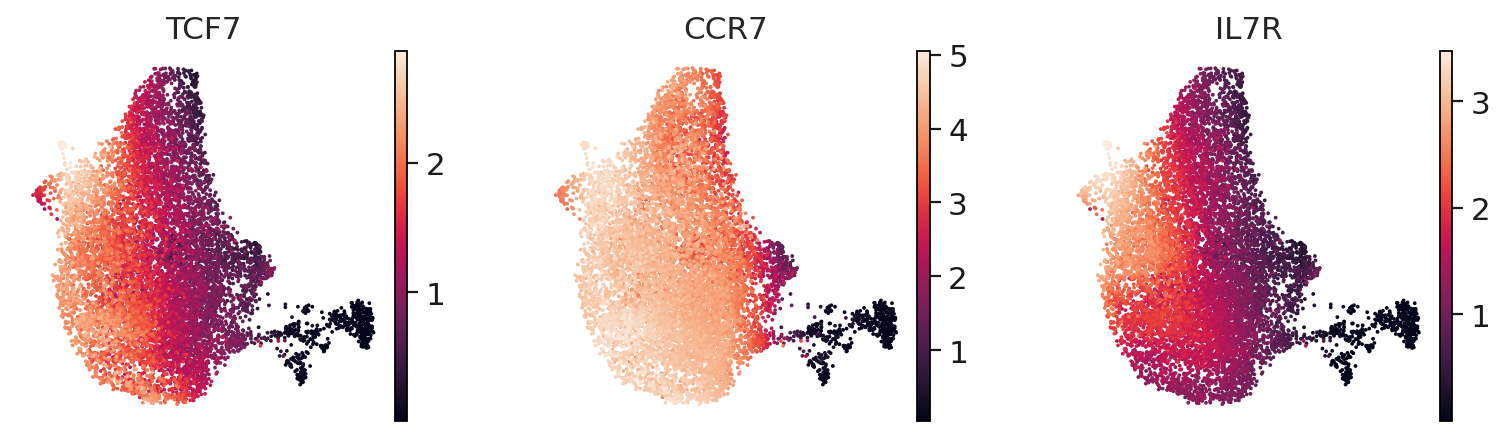

In [19]:
adata.layers['MAGIC_imputed_data'] = palantir.utils.run_magic_imputation(adata, dm_res)
sc.pl.embedding(adata, basis='umap', layer='MAGIC_imputed_data',
               color=['TCF7', 'CCR7', 'IL7R'], save = '_stemness_gene_expression.pdf')

findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: 

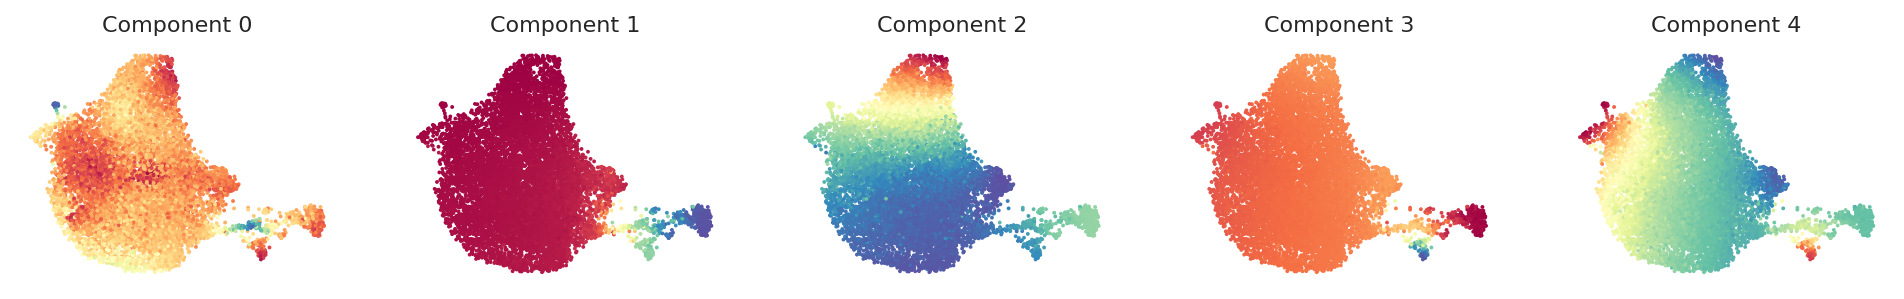

In [20]:
umap = pd.DataFrame(adata.obsm['X_umap'], index=adata.obs_names)
palantir.plot.plot_diffusion_components(umap, dm_res)

In [ ]:
# Check which cell has highest expression of TCF7 -> result: AAGGCAGAGCGTGAGT-1_0 (high salt) and CGAGCACAGCTAGTTC-1_1 (low salt)

#High salt result
bdata_high = adata[adata.obs.treatment == "high_salt"]
expression_df = bdata_high.to_df()[["TCF7"]]

# cell_with_highest_score = bdata_high.obs.index[highest_score_index]

# print the cell with the highest score
print(cell_with_highest_score)


#Low salt
bdata = adata[adata.obs.treatment == "low_salt"]
expression_df_b = bdata.to_df()[["TCF7"]]

# compute the sum of expression levels for these 3 genes for each cell
scores_b = np.sum(expression_df_b, axis=1)

# find the index of the cell with the highest score
highest_score_index_b = np.argmax(scores_b)

# get the cell with the highest score
cell_with_highest_score_b = bdata.obs.index[highest_score_index_b]

# print the cell with the highest score
print(cell_with_highest_score_b)


#adata["AAGGCAGAGCGTGAGT-1_0", :].obs
#adata["CGAGCACAGCTAGTTC-1_1", :].obscompute the sum of expression levels for these 3 genes for each cell
scores = np.sum(expression_df, axis=1)

# find the index of the cell with the highest score
highest_score_index = np.argmax(scores)

# get the cell with the highest score


In [ ]:
# Check which cell has lowest expression of all three stemness genes -> result: AAACCTGAGGAGTTGC-1_0 (high salt) and  AAACCTGCAACTTGAC-1_1 (low salt)

#High salt result
bdata = adata[adata.obs.treatment == "high_salt"]
expression_df = bdata.to_df()[["TCF7", "CCR7", "IL7R"]]

# compute the sum of expression levels for these 3 genes for each cell
scores = np.sum(expression_df, axis=1)

# find the index of the cell with the lowest score
lowest_score_index = np.argmin(scores)

# get the cell with the lowest score
cell_with_lowest_score = bdata.obs.index[lowest_score_index]

# print the cell with the highest score
print(cell_with_lowest_score)

#Low salt
bdata = adata[adata.obs.treatment == "low_salt"]
expression_df = bdata.to_df()[["TCF7", "CCR7", "IL7R"]]

# compute the sum of expression levels for these 3 genes for each cell
scores = np.sum(expression_df, axis=1)

# find the index of the cell with the lowest score
lowest_score_index = np.argmin(scores)

# get the cell with the lowest score
cell_with_lowest_score = bdata.obs.index[lowest_score_index]

# print the cell with the highest score
print(cell_with_lowest_score)


In [53]:
# Running Palantir
terminal_states = pd.Series(['high_salt', 'low_salt'], 
                           index=['AAACCTGAGGAGTTGC-1_0', 'AAACCTGCAACTTGAC-1_1'])

start_cell = 'AAGGCAGAGCGTGAGT-1_0'
pr_res = palantir.core.run_palantir(ms_data, start_cell, num_waypoints=500, terminal_states=terminal_states.index)

Sampling and flocking waypoints...
Time for determining waypoints: 0.013998862107594807 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.33336582978566487 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: 

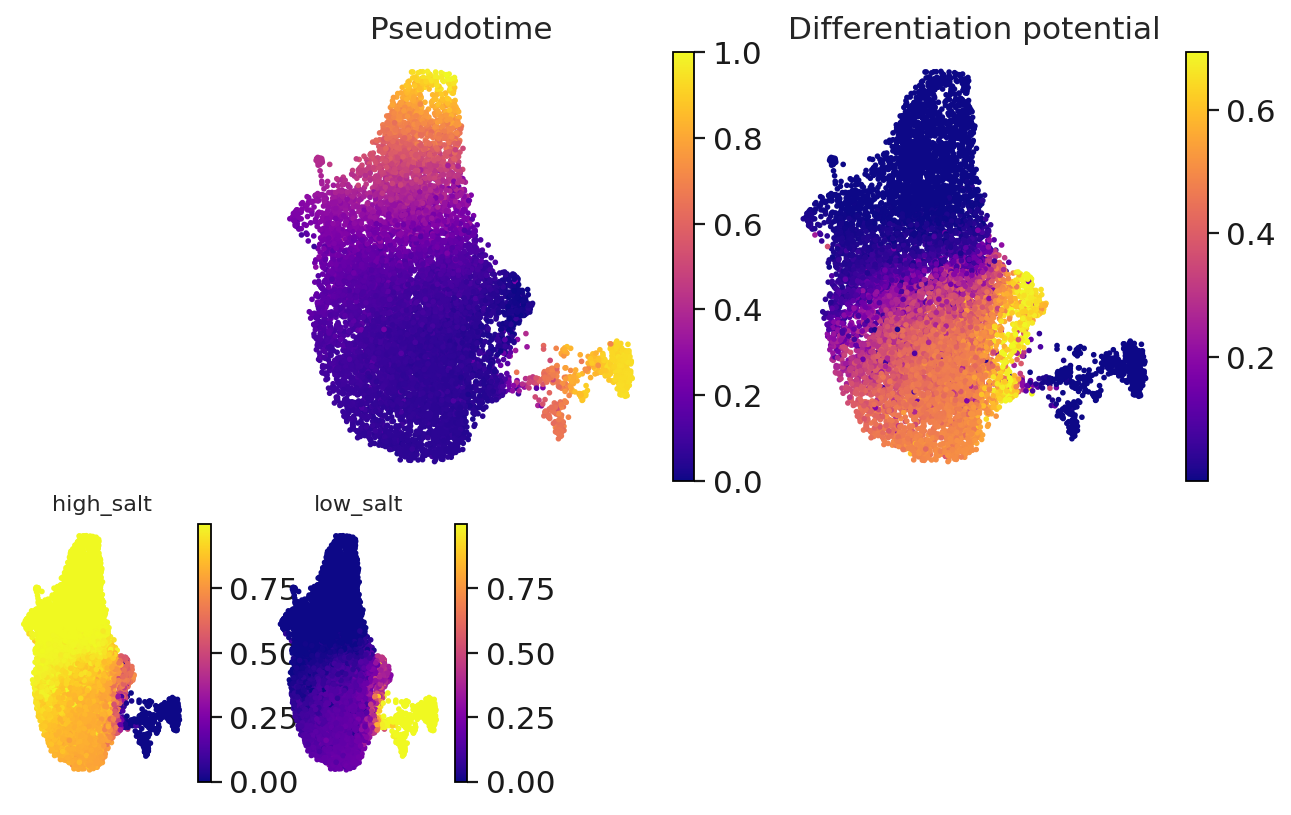

In [55]:
pr_res.branch_probs.columns = terminal_states[pr_res.branch_probs.columns]
palantir.plot.plot_palantir_results(pr_res, umap)

(<Figure size 320x320 with 1 Axes>, <AxesSubplot: >)

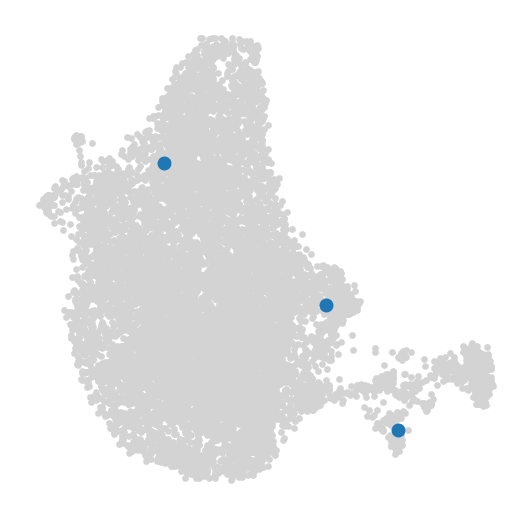

In [63]:
# Highlight cells in UMAP
cells = ['AAGGCAGAGCGTGAGT-1_0', 'AAACCTGAGGAGTTGC-1_0', 'AAACCTGCAACTTGAC-1_1']
palantir.plot.highlight_cells_on_tsne(umap, cells)

c:\users\mahim\appdata\local\programs\python\python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfon

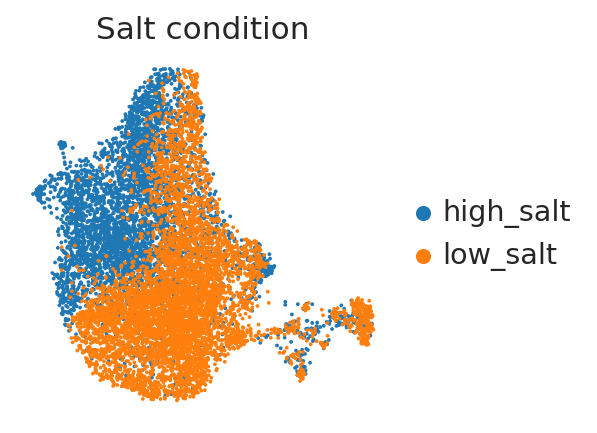

In [60]:
sc.pl.umap(adata, color=['treatment'], title=['Salt condition'])

In [61]:
# Gene expression trends
genes = ["TCF7", "CCR7", "IL7R"]
imp_df = pd.DataFrame(adata[:, genes].layers['MAGIC_imputed_data'],
                     index=adata.obs_names, columns=genes)
gene_trends = palantir.presults.compute_gene_trends( pr_res, imp_df.loc[:, genes])

high_salt
Time for processing high_salt: 0.09340404272079468 minutes
low_salt
Time for processing low_salt: 0.06696168184280396 minutes


findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: 

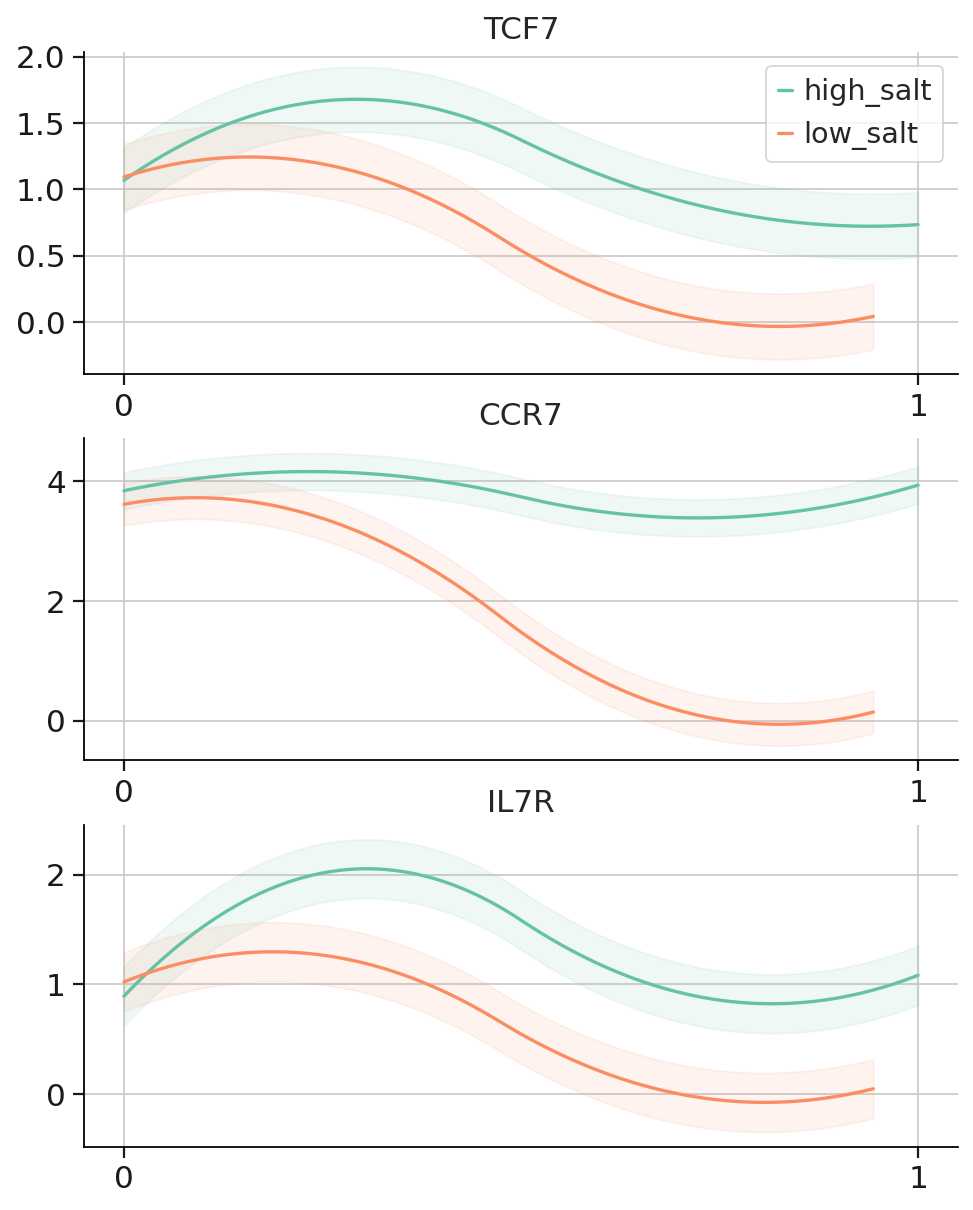

In [62]:
palantir.plot.plot_gene_trends(gene_trends)

findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: 

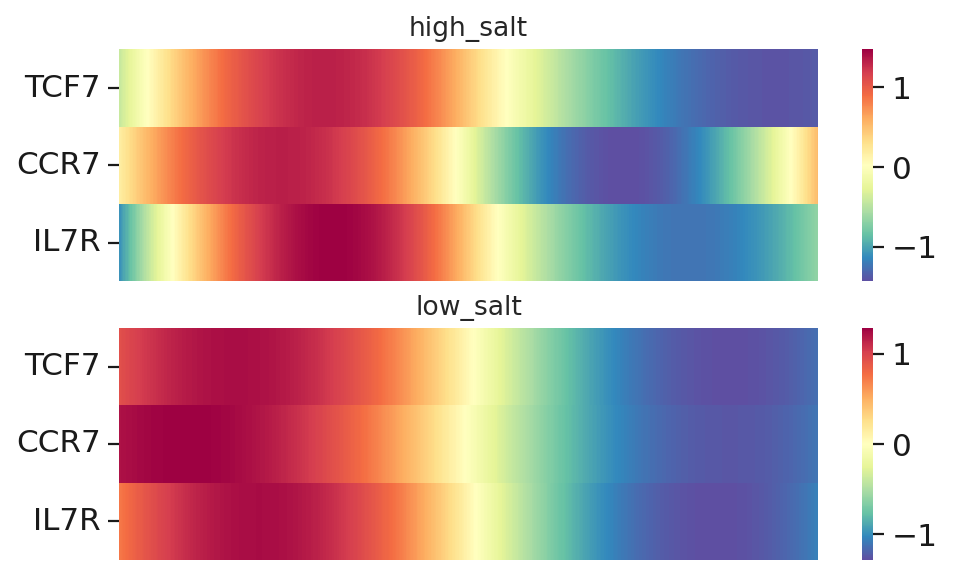

In [65]:
palantir.plot.plot_gene_trend_heatmaps(gene_trends)

Finding 50 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 5.358987092971802 seconds
Jaccard graph constructed in 7.1955790519714355 seconds
Wrote graph to binary file in 0.47512078285217285 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.750128
After 6 runs, maximum modularity is Q = 0.751398
Louvain completed 26 runs in 13.612735509872437 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 29.177578926086426 seconds


findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: 

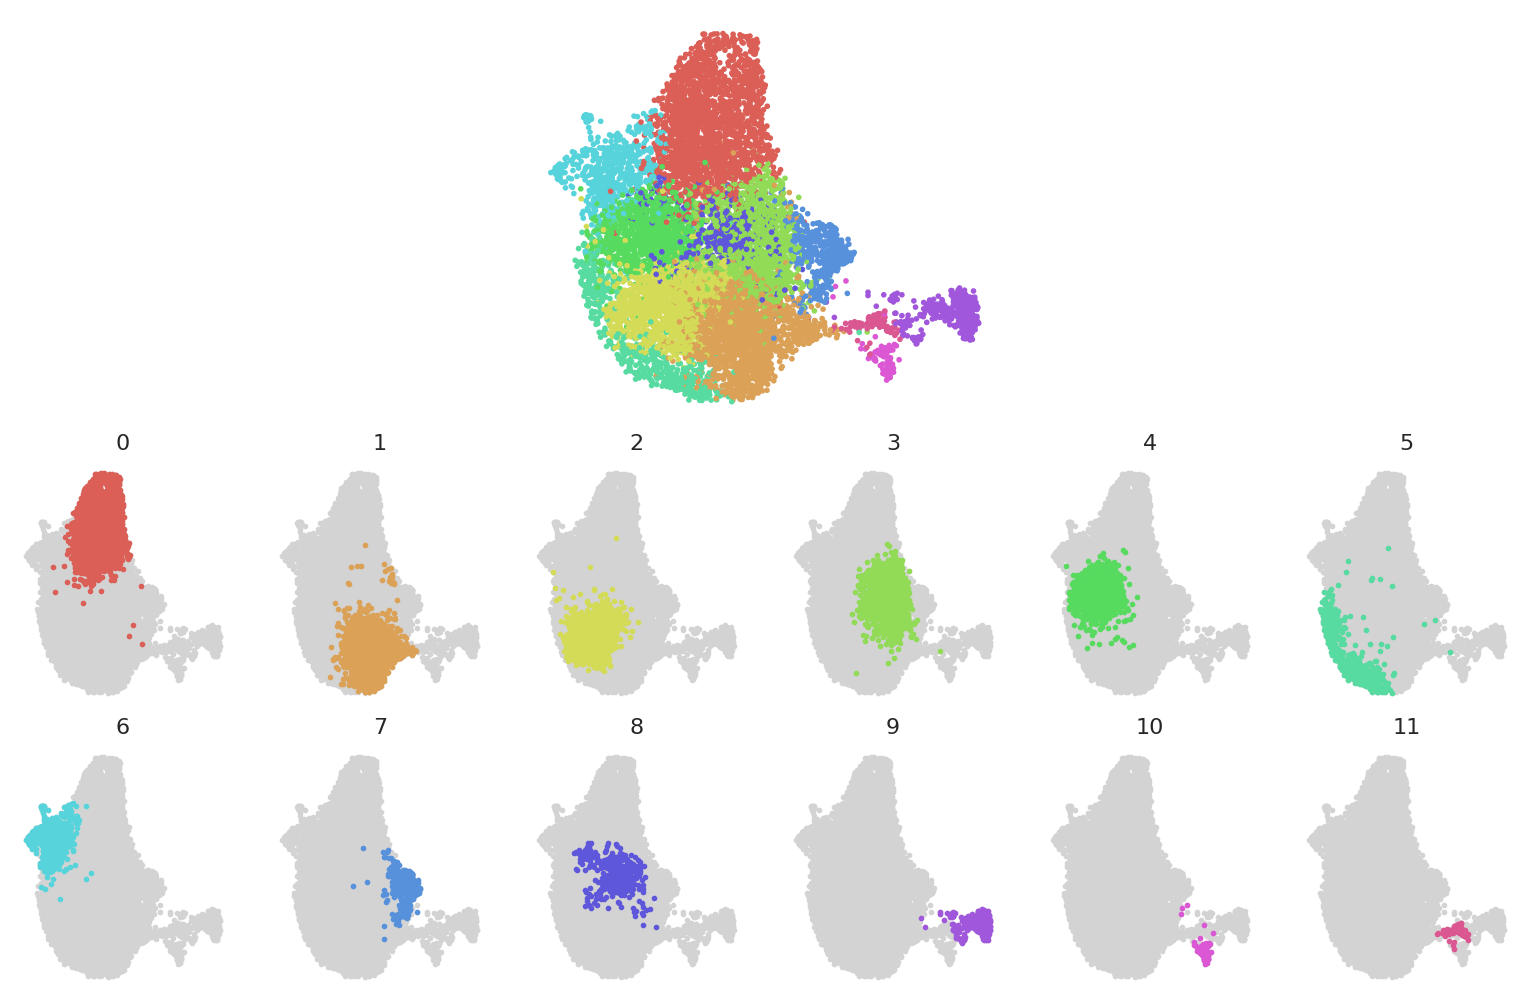

In [66]:
clusters = palantir.utils.determine_cell_clusters(pca_projections)
palantir.plot.plot_cell_clusters(umap, clusters )

high_salt
Time for processing high_salt: 0.6990251700083415 minutes
Finding 150 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.08228182792663574 seconds
Jaccard graph constructed in 6.319248914718628 seconds
Wrote graph to binary file in 0.1215813159942627 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.698503
After 8 runs, maximum modularity is Q = 0.702036
Louvain completed 28 runs in 1.7490513324737549 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 10.264628171920776 seconds


findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: 

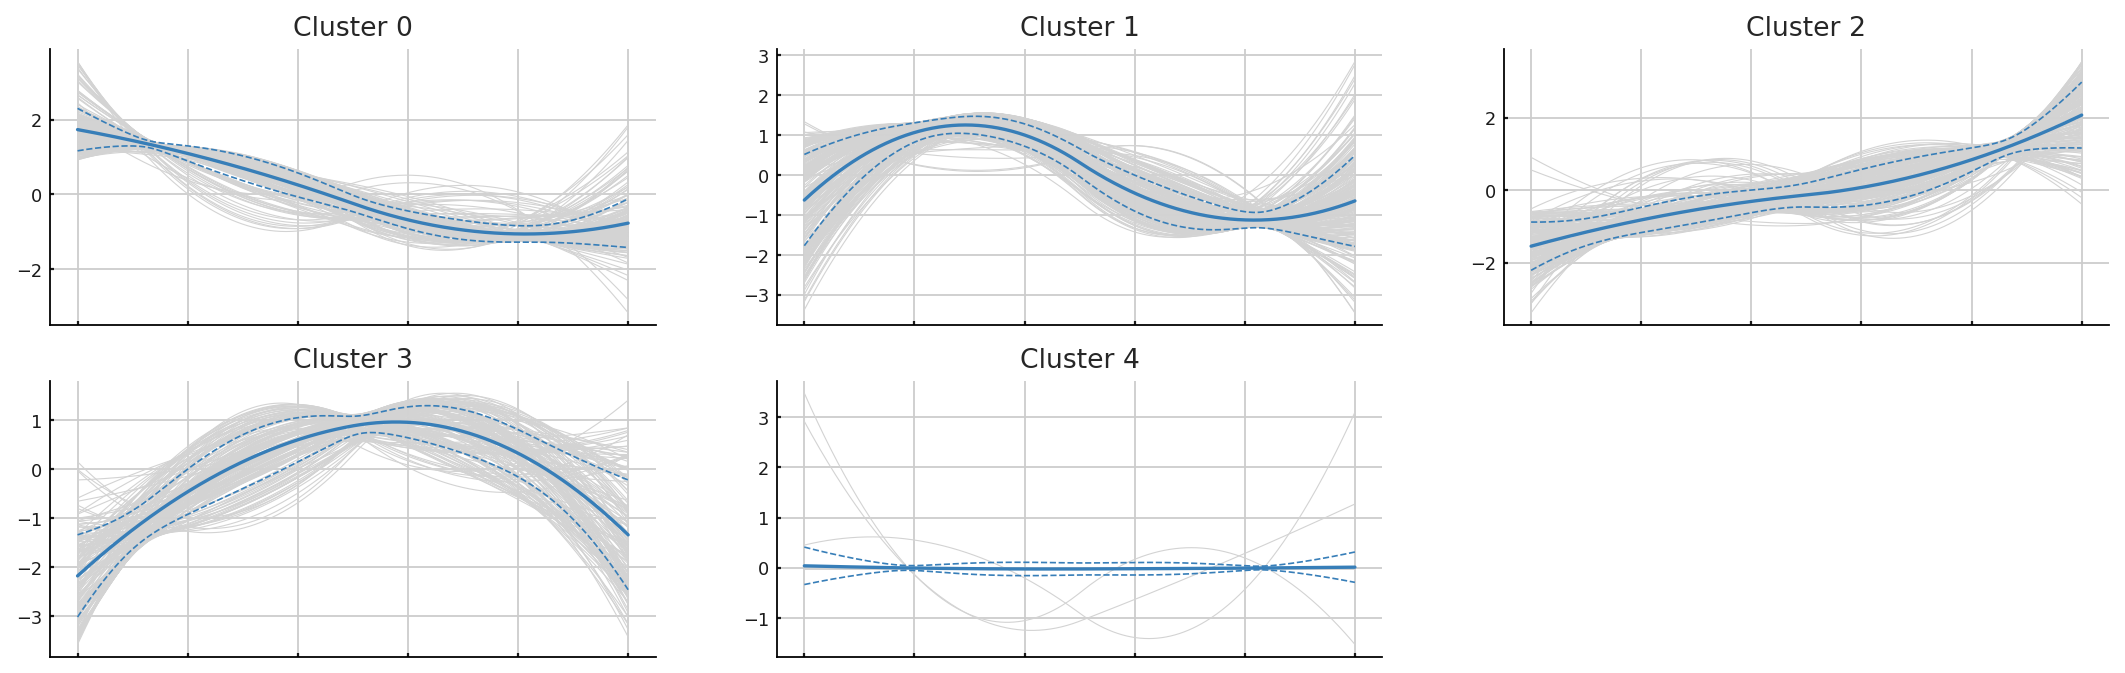

In [72]:
# Clustering for high salt
genes = adata.var_names[:1000]
imp_df = pd.DataFrame(adata[:, genes].layers['MAGIC_imputed_data'], 
                     index=adata.obs_names, columns=genes)
gene_trends = palantir.presults.compute_gene_trends(pr_res, 
                    imp_df.iloc[:, 0:1000], ['high_salt'])

# Cluster
trends = gene_trends['high_salt']['trends']
gene_clusters = palantir.presults.cluster_gene_trends(trends)

palantir.plot.plot_gene_trend_clusters(trends, gene_clusters)

low_salt
Time for processing low_salt: 0.6036144216855367 minutes
Finding 150 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.08634519577026367 seconds
Jaccard graph constructed in 5.876051187515259 seconds
Wrote graph to binary file in 0.060555458068847656 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.710767
After 2 runs, maximum modularity is Q = 0.712534
Louvain completed 22 runs in 1.4448151588439941 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 9.83368182182312 seconds


findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: 

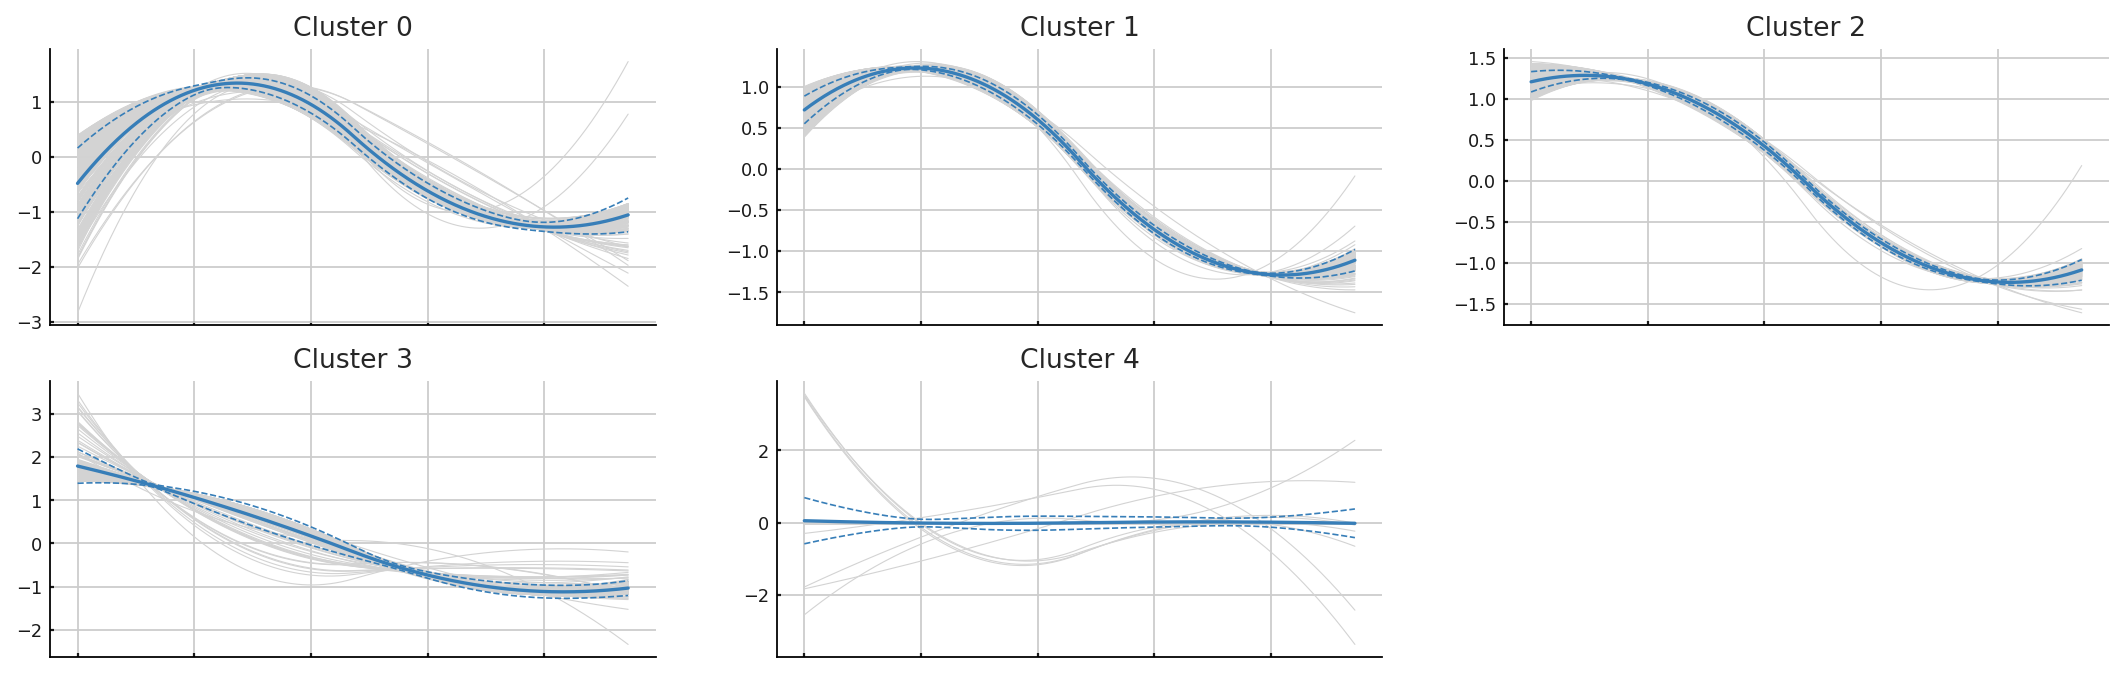

In [73]:
# Clustering for low salt
genes = adata.var_names[:1000]
imp_df = pd.DataFrame(adata[:, genes].layers['MAGIC_imputed_data'], 
                     index=adata.obs_names, columns=genes)
gene_trends = palantir.presults.compute_gene_trends(pr_res, 
                    imp_df.iloc[:, 0:1000], ['low_salt'])

# Cluster
trends = gene_trends['low_salt']['trends']
gene_clusters = palantir.presults.cluster_gene_trends(trends)

palantir.plot.plot_gene_trend_clusters(trends, gene_clusters)